In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [61]:
# Loading the dataset
merged_df=pd.read_parquet("data\\raw\\merged_data_bwp.parquet")
merged_df.head(),merged_df.tail(),merged_df.shape

(                  timestamp  temperature_2m  relative_humidity_2m  \
 0 2025-11-05 00:00:00+00:00           18.40             69.179977   
 1 2025-11-05 01:00:00+00:00           17.85             72.555122   
 2 2025-11-05 02:00:00+00:00           17.65             74.685219   
 3 2025-11-05 03:00:00+00:00           19.25             69.346954   
 4 2025-11-05 04:00:00+00:00           21.90             60.446892   
 
    wind_speed_10m  pressure_msl  wind_direction_10m  precipitation  \
 0        8.936778   1010.599976            9.272532            0.0   
 1        9.761578   1011.299988          354.709991            0.0   
 2       10.837435   1012.200012           11.496537            0.0   
 3       10.308830   1012.799988           24.775122            0.0   
 4        8.155807   1013.599976           22.036283            0.0   
 
    cloud_cover_low       pm10      pm2_5  carbon_monoxide  nitrogen_dioxide  \
 0              0.0  68.199997  64.699997            636.0         18.

In [19]:
# Checking  missing values for each column 
merged_df.isna().sum()
#no missing values for any column

timestamp               0
temperature_2m          0
relative_humidity_2m    0
wind_speed_10m          0
pressure_msl            0
wind_direction_10m      0
precipitation           0
cloud_cover_low         0
pm10                    0
pm2_5                   0
carbon_monoxide         0
nitrogen_dioxide        0
sulphur_dioxide         0
ozone                   0
carbon_dioxide          0
dtype: int64

In [33]:
#checking for duplicate timestamps
merged_df["timestamp"].duplicated().sum()
#no duplicate timestamps


0

In [66]:
# Creating 3 types of derived features : 
#a) time based features (hr,dayOfWeek, day,month) 
#b) lag features (lag 1, 6 and 24)
#c) rolling features (6a nd 24) + pm25_change_1hr 

# TIME BASED FEATURES
merged_df["hour"]=merged_df["timestamp"].dt.hour
merged_df["day_of_week"]=merged_df["timestamp"].dt.dayofweek
merged_df["day"]=merged_df["timestamp"].dt.day
merged_df["month"]=merged_df["timestamp"].dt.month

# LAG FEATURES
merged_df["pm25_lag1"]=merged_df["pm2_5"].shift(1)
merged_df["pm25_lag6"]=merged_df["pm2_5"].shift(6)
merged_df["pm25_lag24"]=merged_df["pm2_5"].shift(24)

# ROLLING FEATURES
merged_df["pm25_ma6"]=merged_df["pm2_5"].rolling(6).mean()
merged_df["pm25_ma24"]=merged_df["pm2_5"].rolling(24).mean()

# CHANGE FEATURE
merged_df["pm25_change_1hr"]=merged_df["pm2_5"]-merged_df["pm25_lag1"]

In [15]:
merged_df.head()
merged_df.tail()

,timestamp,temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl,wind_direction_10m,precipitation,cloud_cover_low,pm10,pm2_5,...,sulphur_dioxide,ozone,carbon_dioxide,hour,day_of_week,day,month,pm25_lag1,pm25_lag6,pm25_lag24
1411,2026-01-02 19:00:00+00:00,10.05,93.506500,4.669604,1019.299988,152.447281,0.0,0.0,134.600006,131.800003,...,10.7,41.0,492.0,19,4,2,1,152.699997,109.400002,143.000000
1412,2026-01-02 20:00:00+00:00,9.75,93.491562,4.471107,1019.000000,139.899155,0.0,0.0,113.900002,111.099998,...,8.1,48.0,492.0,20,4,2,1,131.800003,131.800003,150.899994
1413,2026-01-02 21:00:00+00:00,9.45,93.476570,4.427414,1018.700012,153.435013,0.0,0.0,98.699997,95.699997,...,6.1,54.0,492.0,21,4,2,1,111.099998,149.500000,160.699997
1414,2026-01-02 22:00:00+00:00,9.10,94.736145,4.978554,1018.599976,167.471207,0.0,0.0,88.199997,85.199997,...,5.0,57.0,492.0,22,4,2,1,95.699997,159.699997,168.600006
1415,2026-01-02 23:00:00+00:00,8.90,95.697380,5.269422,1018.099976,172.146774,0.0,0.0,82.400002,79.400002,...,4.4,60.0,492.0,23,4,2,1,85.199997,161.100006,172.300003


In [18]:
# Dropping NaNs introduced by lagging
merged_df=merged_df.dropna()

In [64]:
merged_df.shape

(1416, 15)

In [ ]:
# Summary stats
merged_df.info()
merged_df.describe()

# hourly granularity + no -ve values

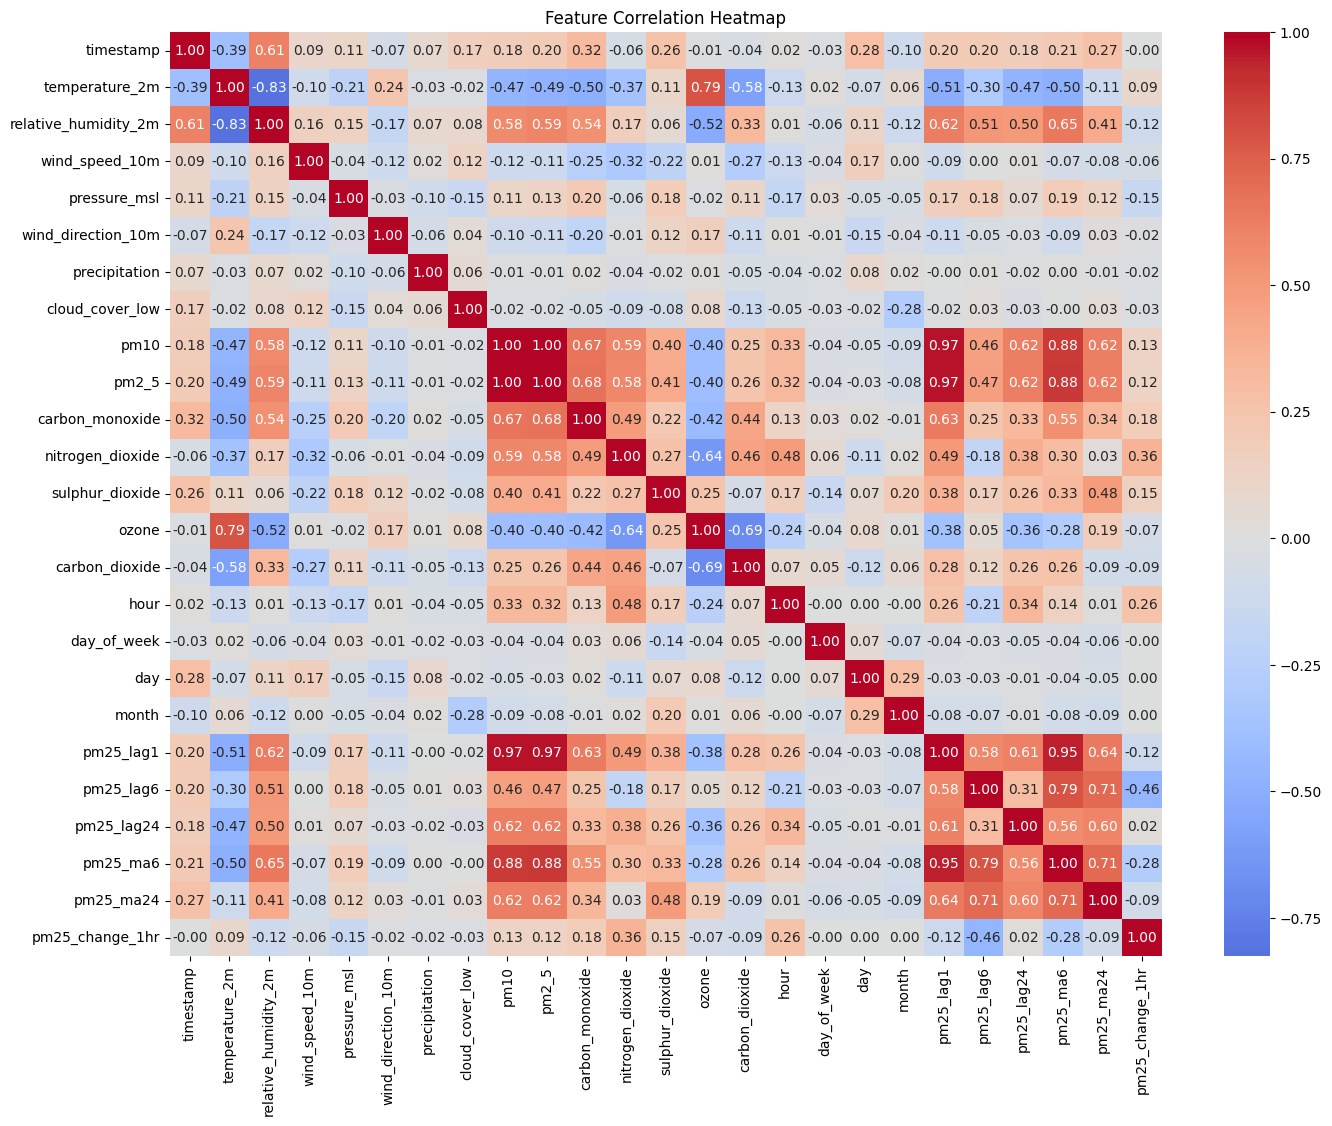

In [68]:
# Correlation Heatmap
plt.figure(figsize=(16,12))
sns.heatmap(
    merged_df.corr(),
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f"
)
plt.title("Feature Correlation Heatmap")
plt.show()

Key Observations:

1: PM2.5 is strongly correlated with lag features, pm10, co and no2

2: Weather effects:

    a) Humidity → positive relation
    b) Temperature → negative relation
    c) Wind speed → dispersion effect
    
3: Some features are noisy or weak

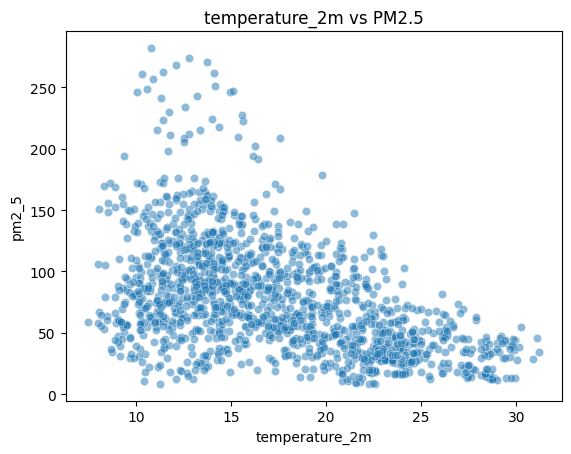

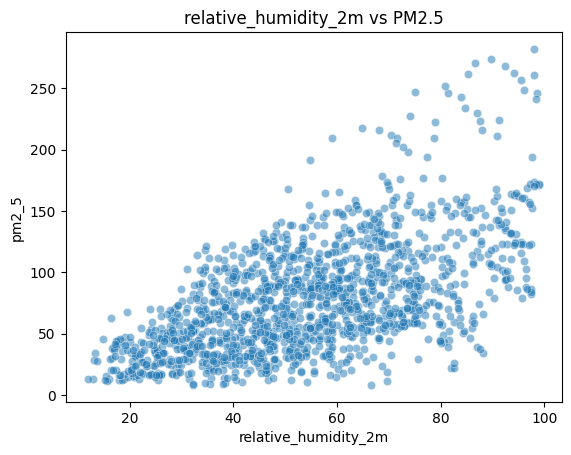

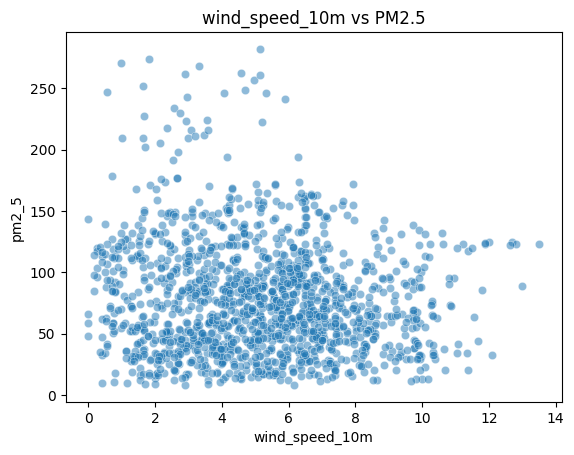

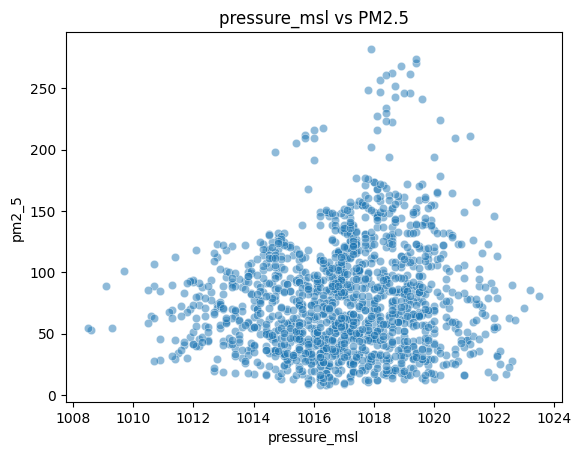

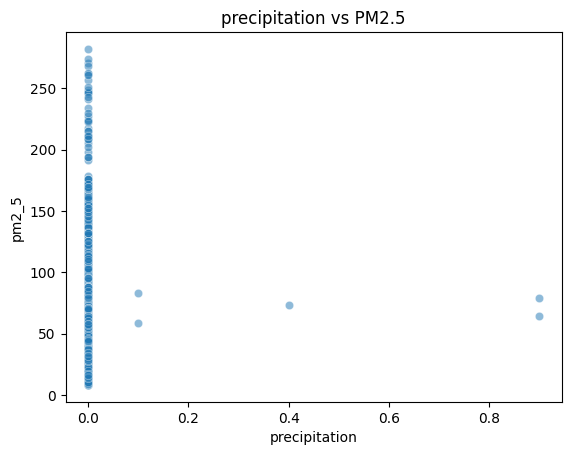

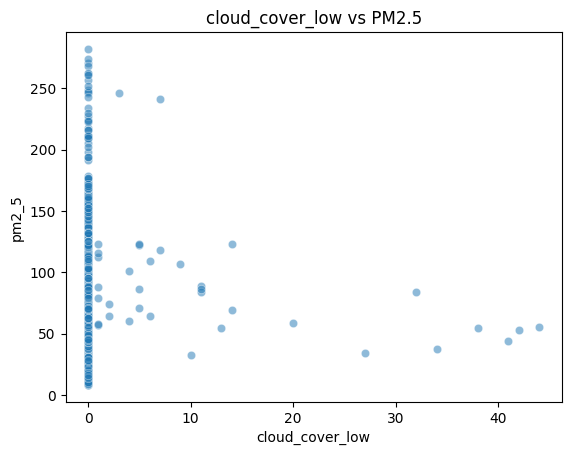

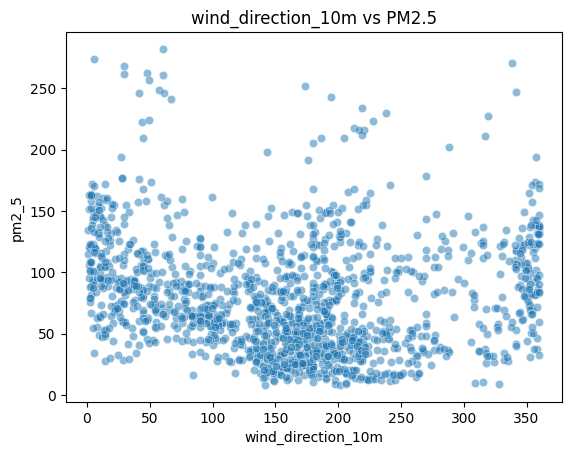

In [69]:
# Checking feature wise relation w target

# Weather Variables
weather_features = [
    "temperature_2m",
    "relative_humidity_2m",
    "wind_speed_10m",
    "pressure_msl",
    "precipitation",
    "cloud_cover_low",
    "wind_direction_10m"
]
for col in weather_features:
    sns.scatterplot(x=col, y="pm2_5", data=merged_df, alpha=0.5)
    plt.title(f"{col} vs PM2.5")
    plt.show()

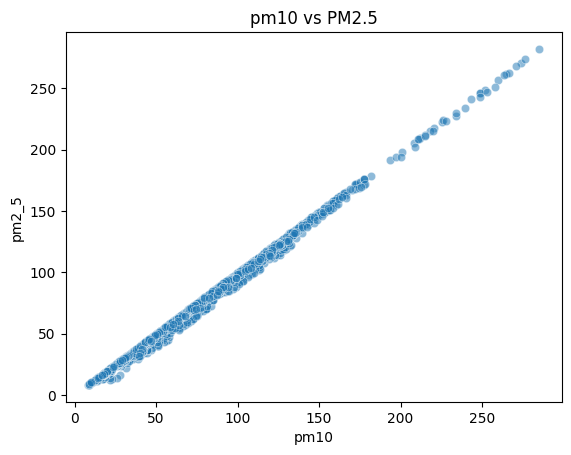

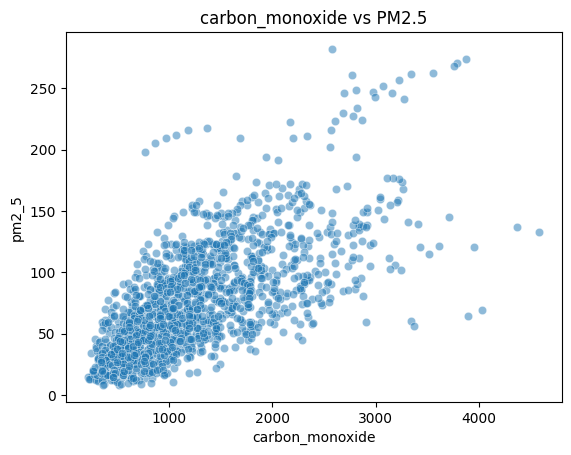

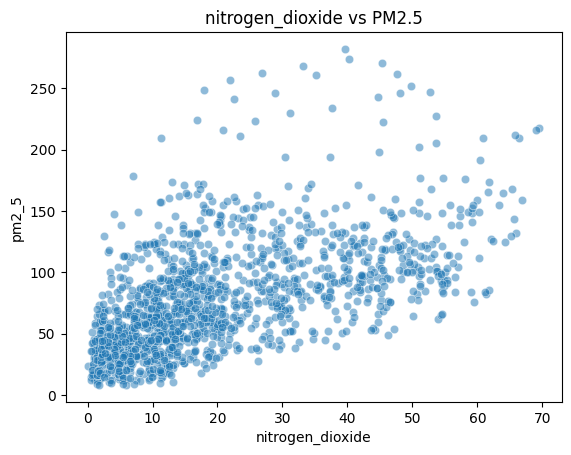

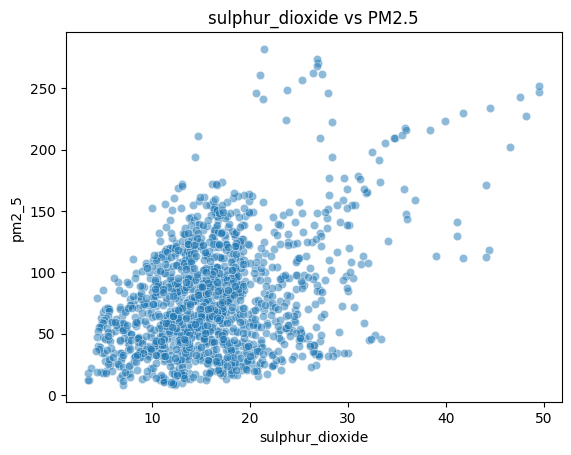

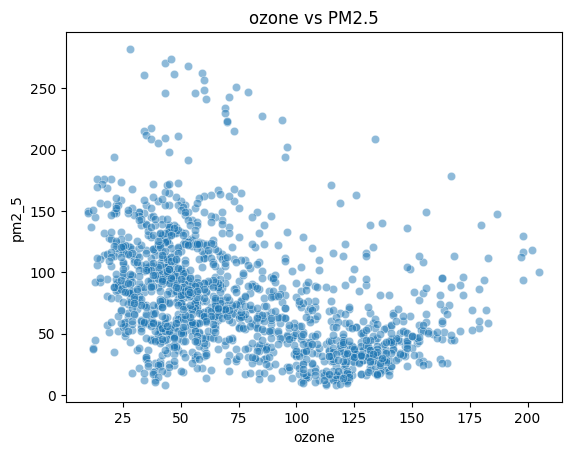

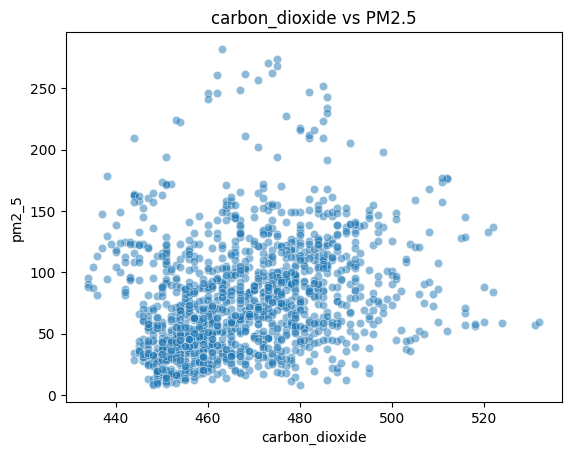

In [70]:
# Pollutants

pollutants = [
    "pm10",
    "carbon_monoxide",
    "nitrogen_dioxide",
    "sulphur_dioxide",
    "ozone",
    "carbon_dioxide"
]
for col in pollutants:
    sns.scatterplot(x=col, y="pm2_5", data=merged_df, alpha=0.5)
    plt.title(f"{col} vs PM2.5")
    plt.show()

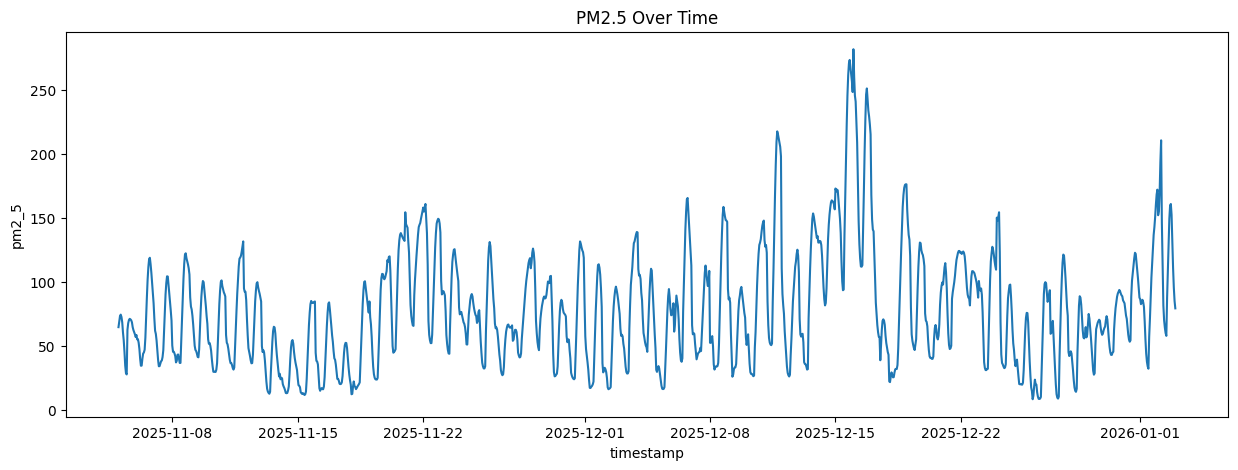

In [78]:
# PM2.5 over time
plt.figure(figsize=(15,5))
sns.lineplot(x='timestamp', y='pm2_5', data=merged_df)
plt.title('PM2.5 Over Time')
plt.show()

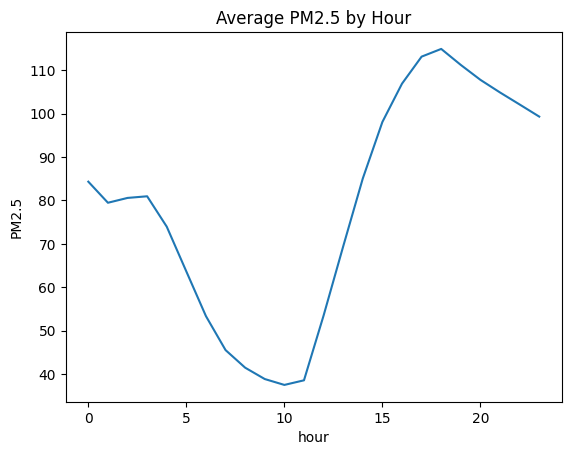

In [72]:
# Hourly trend
merged_df.groupby("hour")["pm2_5"].mean().plot()
plt.title("Average PM2.5 by Hour")
plt.ylabel("PM2.5")
plt.show()

In [73]:
# Validating lag features
merged_df[["pm2_5", "pm25_lag1", "pm25_lag6", "pm25_lag24"]].corr()

,pm2_5,pm25_lag1,pm25_lag6,pm25_lag24
pm2_5,1.000000,0.969053,0.470095,0.618076
pm25_lag1,0.969053,1.000000,0.584655,0.614070
pm25_lag6,0.470095,0.584655,1.000000,0.307042
pm25_lag24,0.618076,0.614070,0.307042,1.000000


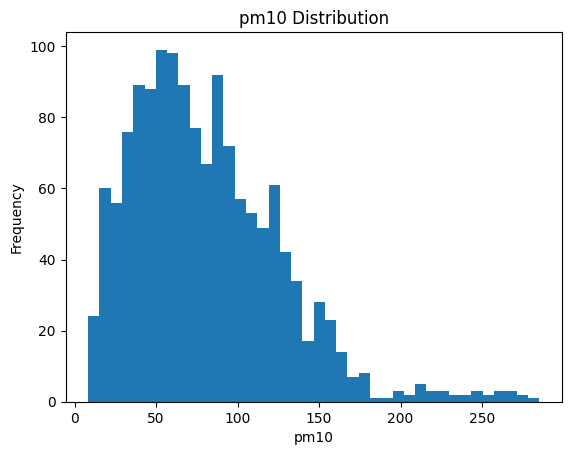

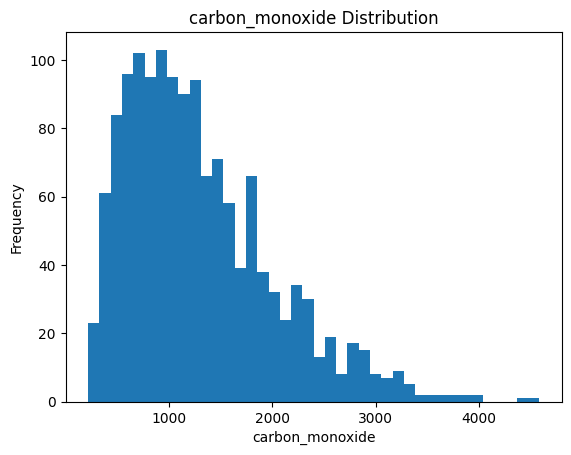

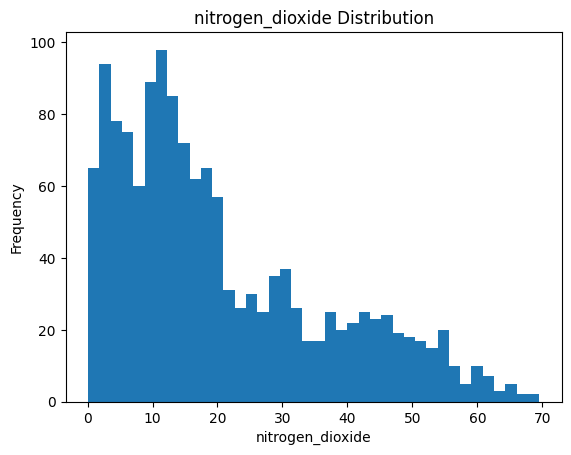

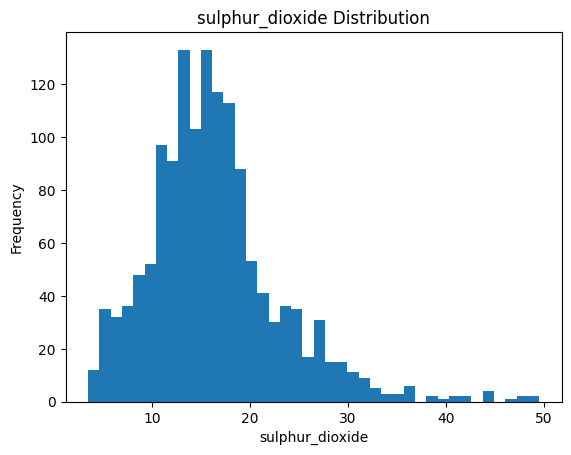

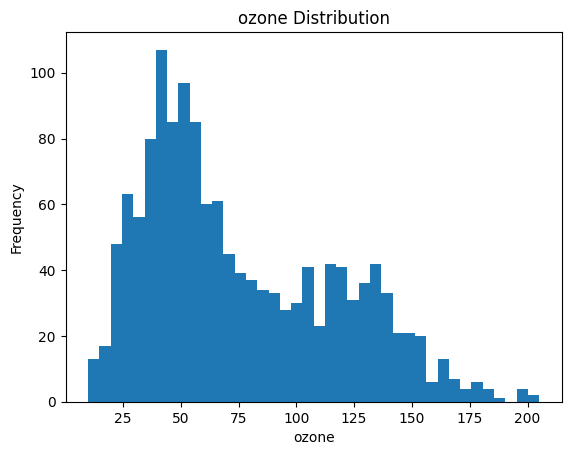

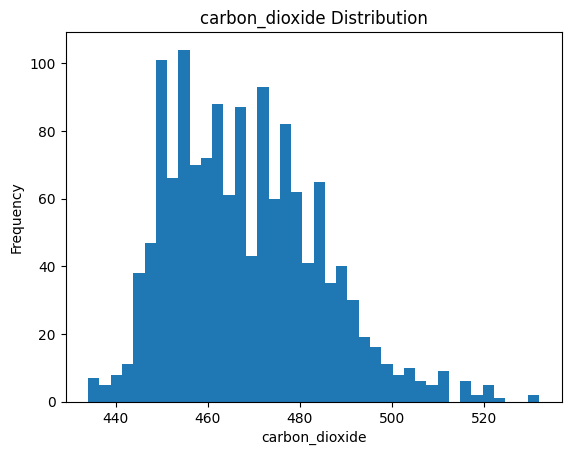

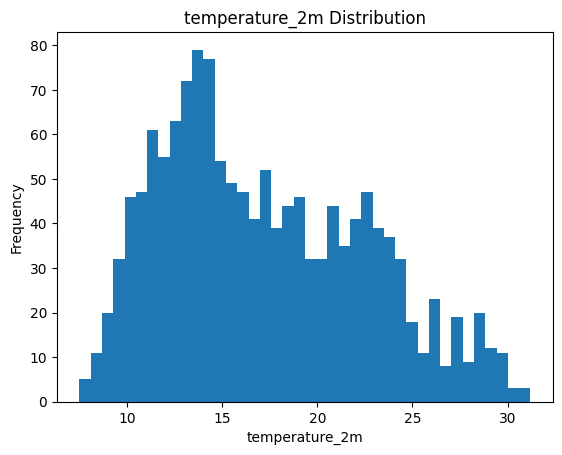

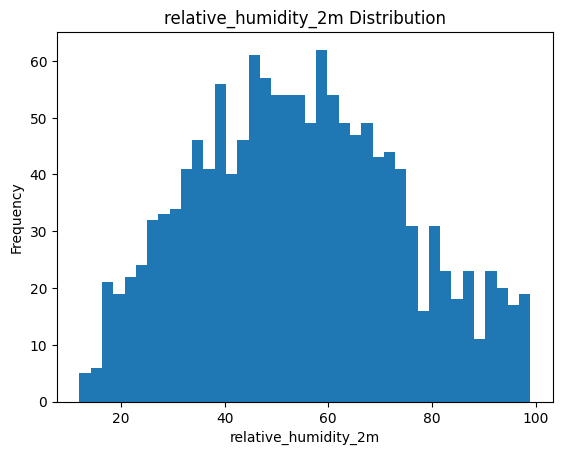

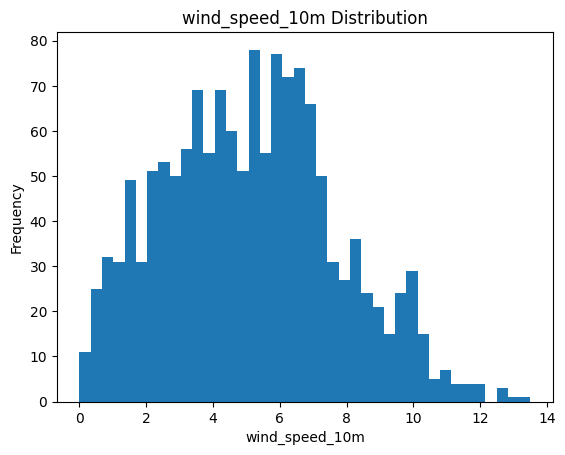

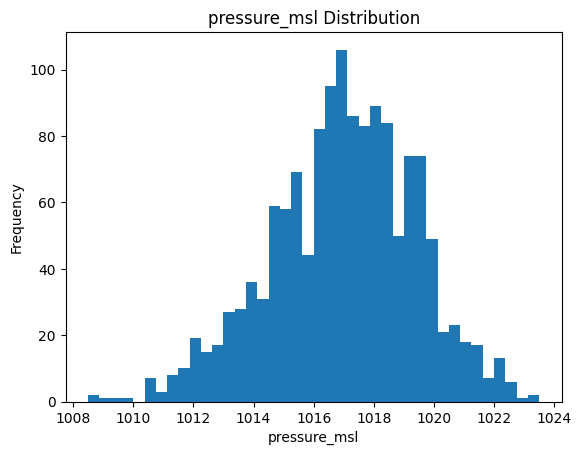

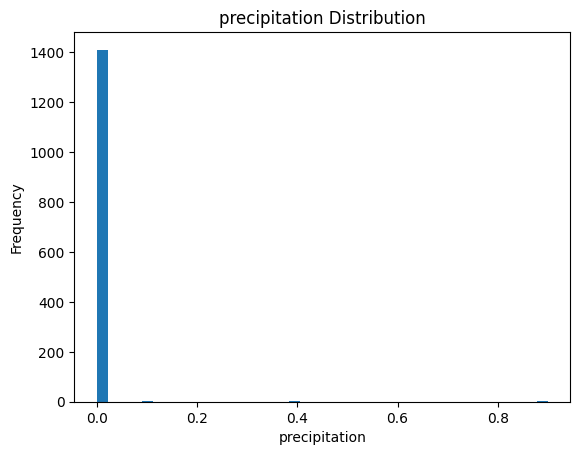

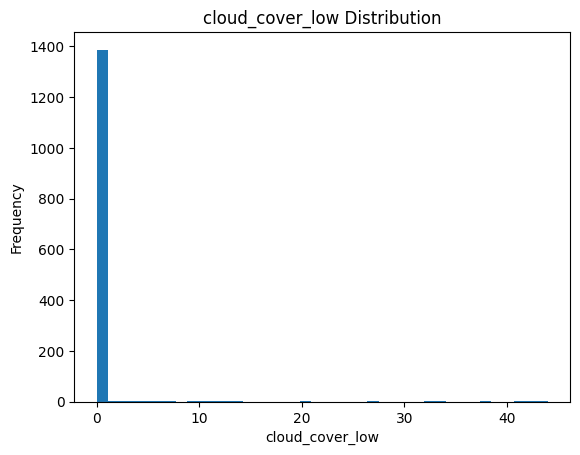

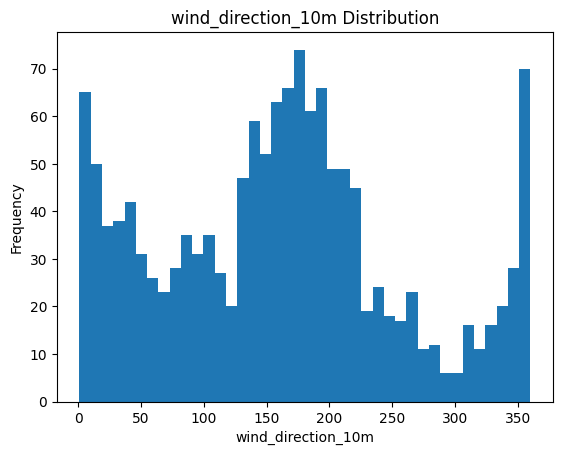

In [74]:
def plot_hist(df, col, bins=40):
    plt.hist(df[col], bins=bins)
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'{col} Distribution')
    plt.show()
for col in pollutants + weather_features:
    plot_hist(merged_df, col)    

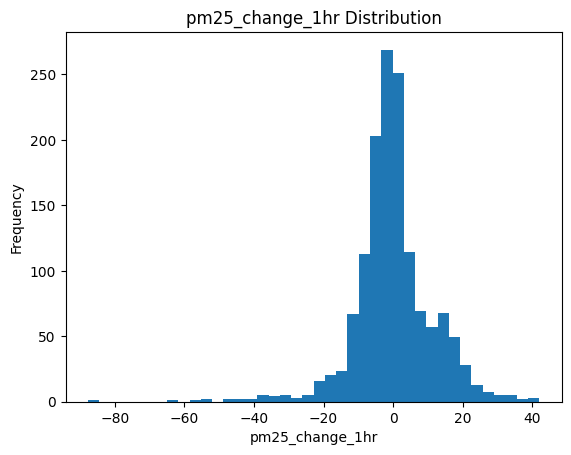

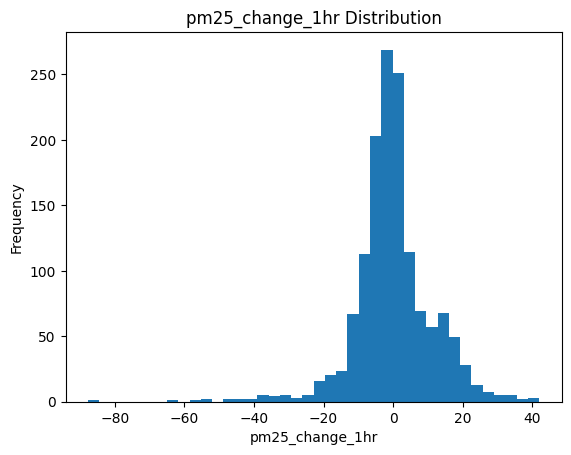

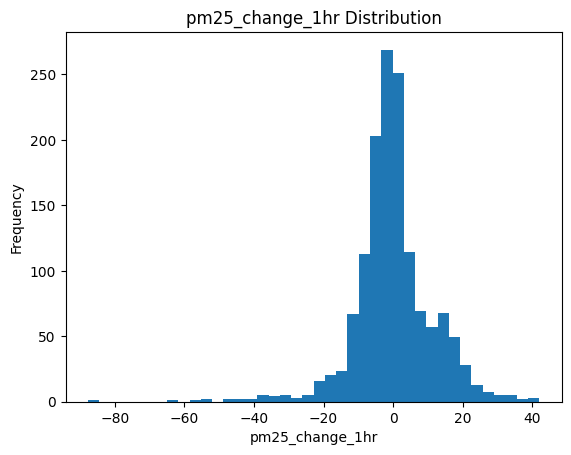

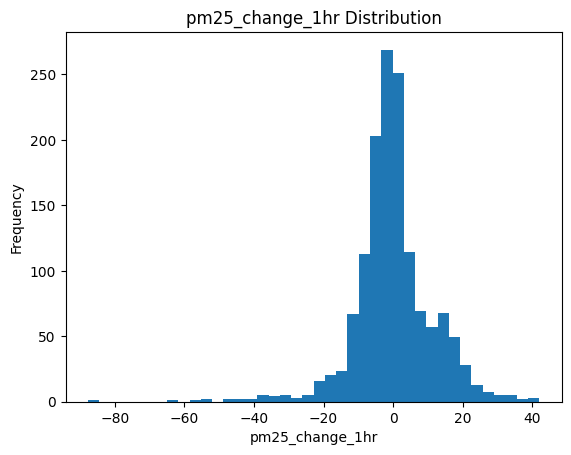

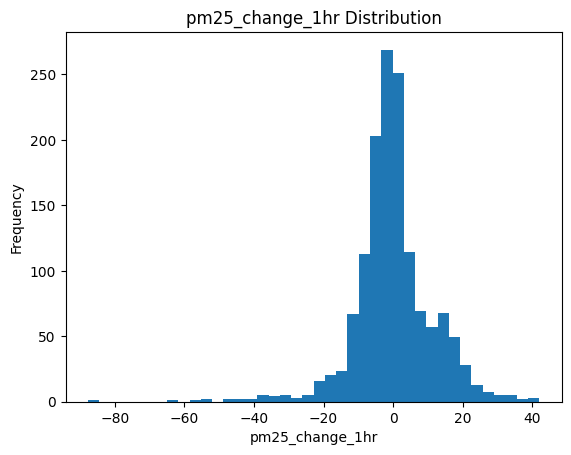

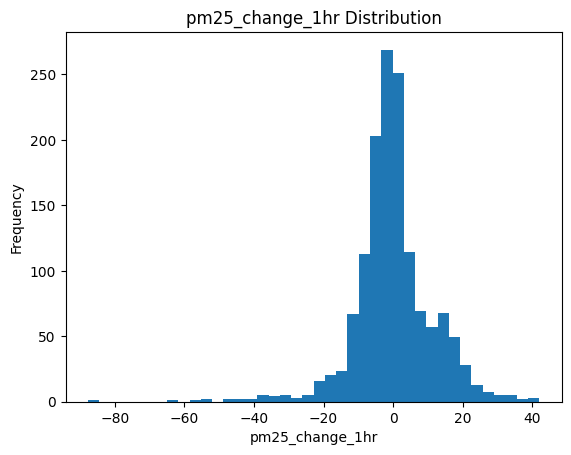

In [75]:
additional_features=['pm25_lag1', 'pm25_lag6', 'pm25_lag24', 'pm25_ma6', 'pm25_ma24', 'pm25_change_1hr']
for col in additional_features:
    plot_hist(merged_df,feature)
                     

In [55]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(merged_df[['pm2_5', 'pm10', 'carbon_monoxide']]))
outliers = (z_scores > 3).any(axis=1)
print("Number of outlier rows:", outliers.sum())

Number of outlier rows: 31


# Final Feature Selection
based on histogram and scatter plot analysis, no strong
relationships were observed between the target and the following features:

a) precipitation
b) cloud_cover_low
c) wind_direction_low
d) day_of_week
e) month

Therefore, these features will be dropped from the dataset

In [79]:
drop_features=["precipitation",
               "cloud_cover_low",
               "wind_direction_10m",
               "day_of_week","month"]
final_df=merged_df.drop(columns=drop_features)
final_df.head()

,timestamp,temperature_2m,relative_humidity_2m,wind_speed_10m,pressure_msl,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,carbon_dioxide,hour,day,pm25_lag1,pm25_lag6,pm25_lag24,pm25_ma6,pm25_ma24,pm25_change_1hr
0,2025-11-05 00:00:00+00:00,18.40,69.179977,8.936778,1010.599976,68.199997,64.699997,636.0,18.700001,6.9,35.0,454.0,0,5,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-11-05 01:00:00+00:00,17.85,72.555122,9.761578,1011.299988,70.500000,69.199997,709.0,17.500000,7.4,37.0,454.0,1,5,64.699997,NaN,NaN,NaN,NaN,4.500000
2,2025-11-05 02:00:00+00:00,17.65,74.685219,10.837435,1012.200012,75.199997,73.300003,816.0,15.800000,8.2,40.0,455.0,2,5,69.199997,NaN,NaN,NaN,NaN,4.100006
3,2025-11-05 03:00:00+00:00,19.25,69.346954,10.308830,1012.799988,76.400002,74.500000,859.0,13.600000,9.1,50.0,455.0,3,5,73.300003,NaN,NaN,NaN,NaN,1.199997
4,2025-11-05 04:00:00+00:00,21.90,60.446892,8.155807,1013.599976,76.400002,72.599998,783.0,10.600000,10.4,74.0,454.0,4,5,74.500000,NaN,NaN,NaN,NaN,-1.900002


In [80]:
# Saving clean dataset
final_df.to_parquet("data/processed/eda_clean_data.parquet", index=False)
final_df.to_csv("data/processed/eda_clean_data.csv", index=False)